# Playground Series S6E1: Predicting Student Test Scores

This notebook provides a comprehensive solution for the Kaggle Playground Series S6E1 competition to predict student test scores.

## Competition Overview
- **Target**: Predict student exam scores (regression)
- **Metric**: Root Mean Squared Error (RMSE)
- **Data**: Synthetically generated dataset with 27 features
- **Duration**: January 1-31, 2026

## Approach
This notebook includes three different methods:
1. **Method 1**: Advanced Feature Engineering + LightGBM (Primary)
2. **Method 2**: Ensemble of LightGBM, XGBoost, and CatBoost
3. **Method 3**: Neural Network + GBDT Hybrid

Run Method 1 first, then try others if needed.

## Table of Contents
1. [Imports & Configuration](#imports-config)
2. [Data Loading](#data-loading)
3. [Exploratory Data Analysis](#eda)
4. [Feature Engineering](#feature-engineering)
5. [Method 1: LightGBM with Advanced FE](#method1)
6. [Method 2: Ensemble Approach](#method2)
7. [Method 3: Neural Network + GBDT](#method3)
8. [Submission](#submission)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import gc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from scipy import stats
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

# Configuration
class CFG:
    INPUT_DIR = '/kaggle/input/playground-series-s6e1/'
    OUTPUT_DIR = '/kaggle/working/'
    N_FOLDS = 5
    SEED = 42
    TARGET = 'exam_score'
    DEBUG = False  # Set True for quick testing

# Create output directory
os.makedirs(CFG.OUTPUT_DIR, exist_ok=True)

# Check GPU availability
import torch
if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    DEVICE = 'cuda'
else:
    print("No GPU available, using CPU")
    DEVICE = 'cpu'

# Set random seeds for reproducibility
np.random.seed(CFG.SEED)
torch.manual_seed(CFG.SEED)

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


GPU available: Tesla P100-PCIE-16GB


## Data Loading <a id='data-loading'></a>

In [2]:
# ===========================================
# DATA LOADING WITH ERROR HANDLING
# ===========================================

# Check if path exists and list files
print("Checking input directory...")
if not os.path.exists(CFG.INPUT_DIR):
    print(f"ERROR: Path not found: {CFG.INPUT_DIR}")
    print("Available paths in /kaggle/input/:")
    print(os.listdir('/kaggle/input/'))
else:
    print(f"Files available: {os.listdir(CFG.INPUT_DIR)}")

# Safe data loading
try:
    train = pd.read_csv(f'{CFG.INPUT_DIR}train.csv')
    test = pd.read_csv(f'{CFG.INPUT_DIR}test.csv')
    sample_submission = pd.read_csv(f'{CFG.INPUT_DIR}sample_submission.csv')
    
    print(f"\nTrain loaded: {train.shape}")
    print(f"Test loaded: {test.shape}")
    print(f"Sample submission: {sample_submission.shape}")
    
    # Store test IDs for submission
    test_ids = test['id'].copy()
    
except FileNotFoundError as e:
    print(f"ERROR loading data: {e}")
    print(f"Check the correct file names in: {CFG.INPUT_DIR}")
    raise

# Quick data overview
print("\n=== DATA OVERVIEW ===")
print(f"\nTrain columns: {list(train.columns)}")
print(f"\nTest columns: {list(test.columns)}")
print(f"\nData types:\n{train.dtypes.value_counts()}")

# Check for missing values
print(f"\nMissing values in train:\n{train.isnull().sum().sum()} total")
print(f"Missing values in test:\n{test.isnull().sum().sum()} total")

# Target distribution
print(f"\nTarget statistics:")
print(train[CFG.TARGET].describe())

Checking input directory...
Files available: ['sample_submission.csv', 'train.csv', 'test.csv']

Train loaded: (630000, 13)
Test loaded: (270000, 12)
Sample submission: (270000, 2)

=== DATA OVERVIEW ===

Train columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']

Test columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

Data types:
object     7
float64    4
int64      2
Name: count, dtype: int64

Missing values in train:
0 total
Missing values in test:
0 total

Target statistics:
count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64


## Exploratory Data Analysis <a id='eda'></a>

=== EXPLORATORY DATA ANALYSIS ===



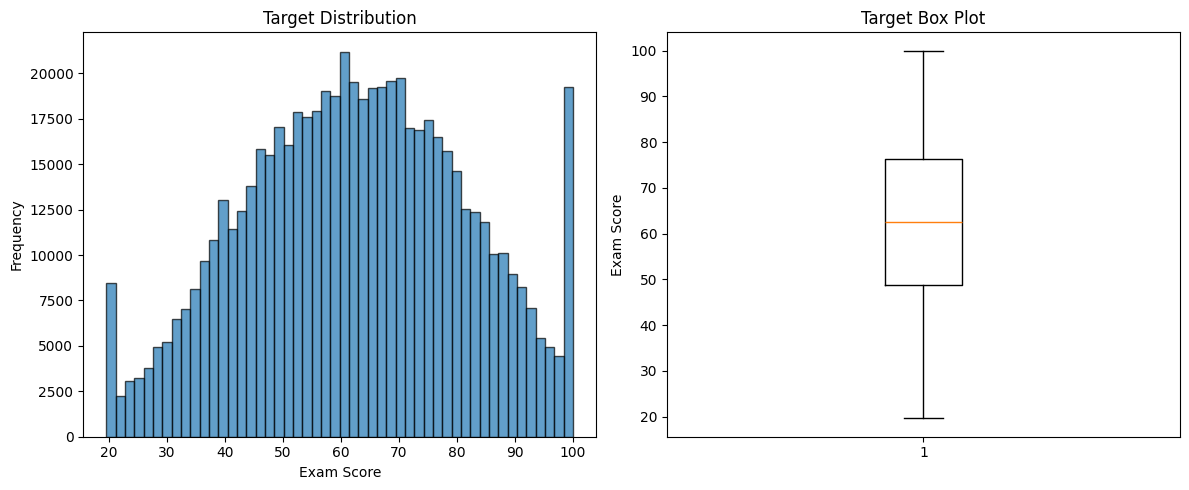

Target Distribution Summary:
Mean: 62.51
Std: 18.92
Min: 19.60
Max: 100.00
Skewness: -0.048
Kurtosis: -0.619

Categorical features (7): ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
Numerical features (5): ['id', 'age', 'study_hours', 'class_attendance', 'sleep_hours']...

=== CATEGORICAL FEATURES ANALYSIS ===

gender:
gender
other     211097
male      210593
female    208310
Name: count, dtype: int64

course:
course
b.tech    131236
b.sc      111554
b.com     110932
bca        88721
bba        75644
Name: count, dtype: int64

internet_access:
internet_access
yes    579423
no      50577
Name: count, dtype: int64

sleep_quality:
sleep_quality
poor       213675
good       213089
average    203236
Name: count, dtype: int64

study_method:
study_method
coaching         131697
self-study       131131
mixed            123086
group study      123009
online videos    121077
Name: count, dtype: int64

=== NUMERICAL FEATURES ANALYSI

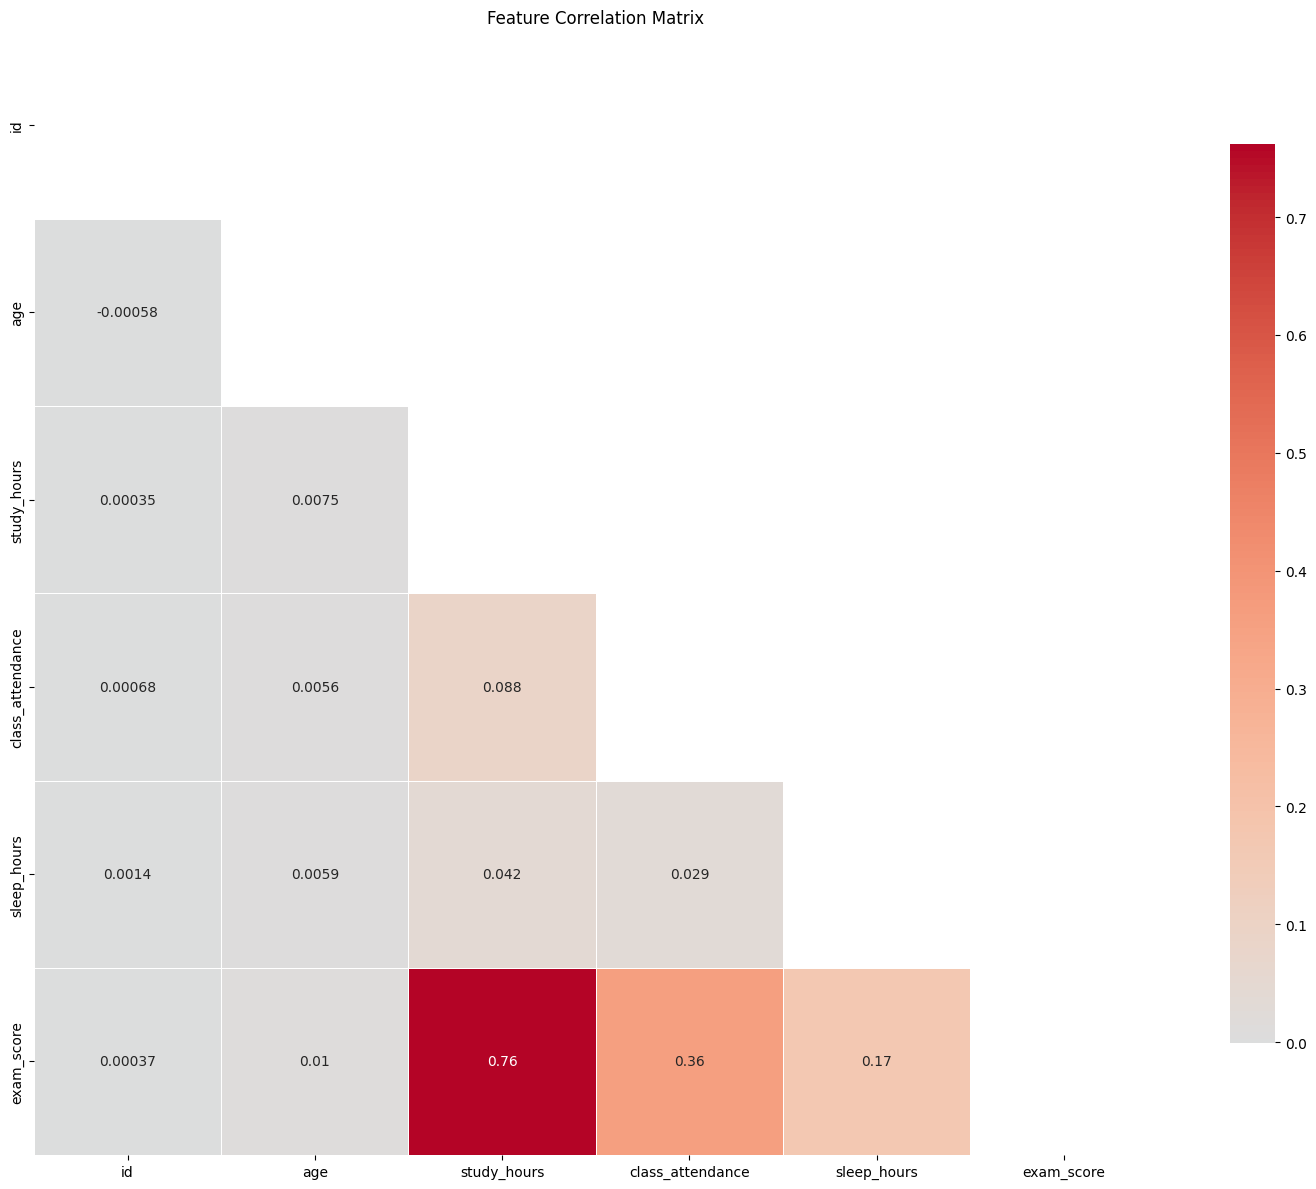


Top correlations with target:
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
id                  0.000372
Name: exam_score, dtype: float64


In [3]:
# ===========================================
# EXPLORATORY DATA ANALYSIS
# ===========================================

print("=== EXPLORATORY DATA ANALYSIS ===\n")

# 1. Target Distribution Analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train[CFG.TARGET], bins=50, alpha=0.7, edgecolor='black')
plt.title('Target Distribution')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(train[CFG.TARGET])
plt.title('Target Box Plot')
plt.ylabel('Exam Score')

plt.tight_layout()
plt.savefig(f'{CFG.OUTPUT_DIR}target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Text summary
print("Target Distribution Summary:")
print(f"Mean: {train[CFG.TARGET].mean():.2f}")
print(f"Std: {train[CFG.TARGET].std():.2f}")
print(f"Min: {train[CFG.TARGET].min():.2f}")
print(f"Max: {train[CFG.TARGET].max():.2f}")
print(f"Skewness: {stats.skew(train[CFG.TARGET]):.3f}")
print(f"Kurtosis: {stats.kurtosis(train[CFG.TARGET]):.3f}")

# 2. Feature Type Identification
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove(CFG.TARGET)  # Remove target

print(f"\nCategorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical features ({len(numerical_cols)}): {numerical_cols[:10]}...")  # Show first 10

# 3. Categorical Feature Analysis
if categorical_cols:
    print("\n=== CATEGORICAL FEATURES ANALYSIS ===")
    for col in categorical_cols[:5]:  # Show top 5
        print(f"\n{col}:")
        print(train[col].value_counts().head())

# 4. Numerical Feature Analysis
print("\n=== NUMERICAL FEATURES ANALYSIS ===")
numerical_stats = train[numerical_cols].describe()
print(numerical_stats.loc[['mean', 'std', 'min', 'max']])

# 5. Correlation Analysis
plt.figure(figsize=(15, 12))
correlation_matrix = train[numerical_cols + [CFG.TARGET]].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(f'{CFG.OUTPUT_DIR}correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Show top correlations with target
print("\nTop correlations with target:")
target_corr = correlation_matrix[CFG.TARGET].drop(CFG.TARGET).abs().sort_values(ascending=False)
print(target_corr.head(10))

## Feature Engineering <a id='feature-engineering'></a>

In [4]:
# ===========================================
# FEATURE ENGINEERING (FIXED + CONSISTENT)
# ===========================================

print("=== FEATURE ENGINEERING ===\n")

# Reset global storages each time you run this cell
label_encoders = {}
target_encoded_features = {}
freq_encoded_features = {}
log_transform_cols = []
global_target_mean = None

def create_features(df, is_train=True, target_col=CFG.TARGET):
    """
    Create features for train and test in a consistent way.
    Train: fit encoders and store maps.
    Test : transform using stored maps.
    """
    global global_target_mean, log_transform_cols

    df = df.copy()

    # Keep target if present, drop id
    if "id" in df.columns:
        df = df.drop("id", axis=1)

    categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if target_col in numerical_cols:
        numerical_cols.remove(target_col)

    print(f"Processing {len(categorical_cols)} categorical and {len(numerical_cols)} numerical features")

    # 1) Label encoding
    for col in categorical_cols:
        if is_train:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
        else:
            le = label_encoders[col]
            mapping = {cls: i for i, cls in enumerate(le.classes_)}
            df[col] = df[col].astype(str).map(mapping).fillna(-1).astype(int)

    # 2) Target encoding
    if is_train:
        global_target_mean = df[target_col].mean()
        for col in categorical_cols:
            m = df.groupby(col)[target_col].mean()
            target_encoded_features[col] = m
            df[f"{col}_target_enc"] = df[col].map(m)
    else:
        for col in categorical_cols:
            m = target_encoded_features.get(col, None)
            if m is None:
                df[f"{col}_target_enc"] = global_target_mean
            else:
                df[f"{col}_target_enc"] = df[col].map(m).fillna(global_target_mean)

    # 3) Interactions (top numeric cols)
    if len(numerical_cols) >= 2:
        top_num = numerical_cols[:5]
        for i, col1 in enumerate(top_num):
            for col2 in top_num[i + 1:]:
                df[f"{col1}_{col2}_interaction"] = df[col1] * df[col2]
                df[f"{col1}_{col2}_ratio"] = df[col1] / (df[col2] + 1e-8)

    # 4) Polynomial
    for col in numerical_cols[:3]:
        df[f"{col}_squared"] = df[col] ** 2
        df[f"{col}_cubed"] = df[col] ** 3
        df[f"{col}_sqrt"] = np.sqrt(np.abs(df[col]))

    # 5) Binning
    for col in numerical_cols[:3]:
        df[f"{col}_binned"] = pd.cut(df[col], bins=5, labels=False).astype("float32").fillna(-1)

    # 6) Log transforms (decide on train only, apply same cols on test)
    if is_train:
        log_transform_cols = []
        for col in numerical_cols:
            try:
                if df[col].skew() > 1.0:
                    log_transform_cols.append(col)
            except Exception:
                pass

    for col in log_transform_cols:
        df[f"{col}_log"] = np.log1p(np.abs(df[col]))

    # 7) Frequency encoding (train fit, test transform)
    if is_train:
        for col in categorical_cols:
            freq = df[col].value_counts(normalize=True)
            freq_encoded_features[col] = freq
            df[f"{col}_freq"] = df[col].map(freq)
    else:
        for col in categorical_cols:
            freq = freq_encoded_features.get(col, None)
            if freq is None:
                df[f"{col}_freq"] = 0.0
            else:
                df[f"{col}_freq"] = df[col].map(freq).fillna(0.0)

    # Safety cleanup
    df = df.replace([np.inf, -np.inf], np.nan)

    print(f"Feature engineering complete. New shape: {df.shape}")
    return df

# Build train features
print("Creating features for training data...")
train_fe = create_features(train, is_train=True, target_col=CFG.TARGET)

y_train = train_fe[CFG.TARGET].copy()
X_train = train_fe.drop(CFG.TARGET, axis=1)

# Build test features
print("\nCreating features for test data...")
X_test = create_features(test, is_train=False, target_col=CFG.TARGET)

# Align columns strictly (important)
extra_cols = set(X_test.columns) - set(X_train.columns)
if extra_cols:
    X_test = X_test.drop(list(extra_cols), axis=1)

missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0

X_test = X_test.reindex(columns=X_train.columns)

# Fill NaNs (from target enc for unseen or any transforms)
X_train = X_train.fillna(global_target_mean)
X_test = X_test.fillna(global_target_mean)

# Remove constant features (fit on train, apply to test)
constant_features = X_train.columns[X_train.nunique() <= 1]
if len(constant_features) > 0:
    print(f"Removing {len(constant_features)} constant features")
    X_train = X_train.drop(constant_features, axis=1)
    X_test = X_test.drop(constant_features, axis=1)

# Optional: reduce memory
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

print(f"\nFinal training shape: {X_train.shape}")
print(f"Final test shape: {X_test.shape}")
print(f"Final feature count: {X_train.shape[1]}")

=== FEATURE ENGINEERING ===

Creating features for training data...
Processing 7 categorical and 4 numerical features
Feature engineering complete. New shape: (630000, 50)

Creating features for test data...
Processing 7 categorical and 4 numerical features
Feature engineering complete. New shape: (270000, 49)

Final training shape: (630000, 49)
Final test shape: (270000, 49)
Final feature count: 49


## Method 1: LightGBM with Advanced Feature Engineering <a id='method1'></a>

=== METHOD 1: LIGHTGBM WITH ADVANCED FEATURE ENGINEERING ===

Training with 5-fold CV...
Train rows: 630000 | Features: 49

Fold 1/5
Fold RMSE: 8.77465

Fold 2/5
Fold RMSE: 8.77928

Fold 3/5
Fold RMSE: 8.76586

Fold 4/5
Fold RMSE: 8.78792

Fold 5/5
Fold RMSE: 8.80022

=== CV RESULTS ===
Mean RMSE: 8.78159 ± 0.01173
Fold scores: ['8.77465', '8.77928', '8.76586', '8.78792', '8.80022']

Clipping predictions to range [19.6, 100.0]
Method 1 predictions shape: (270000,)

Top 15 Important Features:
                                     feature    importance
24  study_hours_class_attendance_interaction  7.125140e+08
3                                study_hours  1.453082e+08
26       study_hours_sleep_hours_interaction  1.031659e+08
14                  sleep_quality_target_enc  3.467977e+07
4                           class_attendance  3.192862e+07
15                   study_method_target_enc  2.729260e+07
28  class_attendance_sleep_hours_interaction  2.659045e+07
16                facility_rati

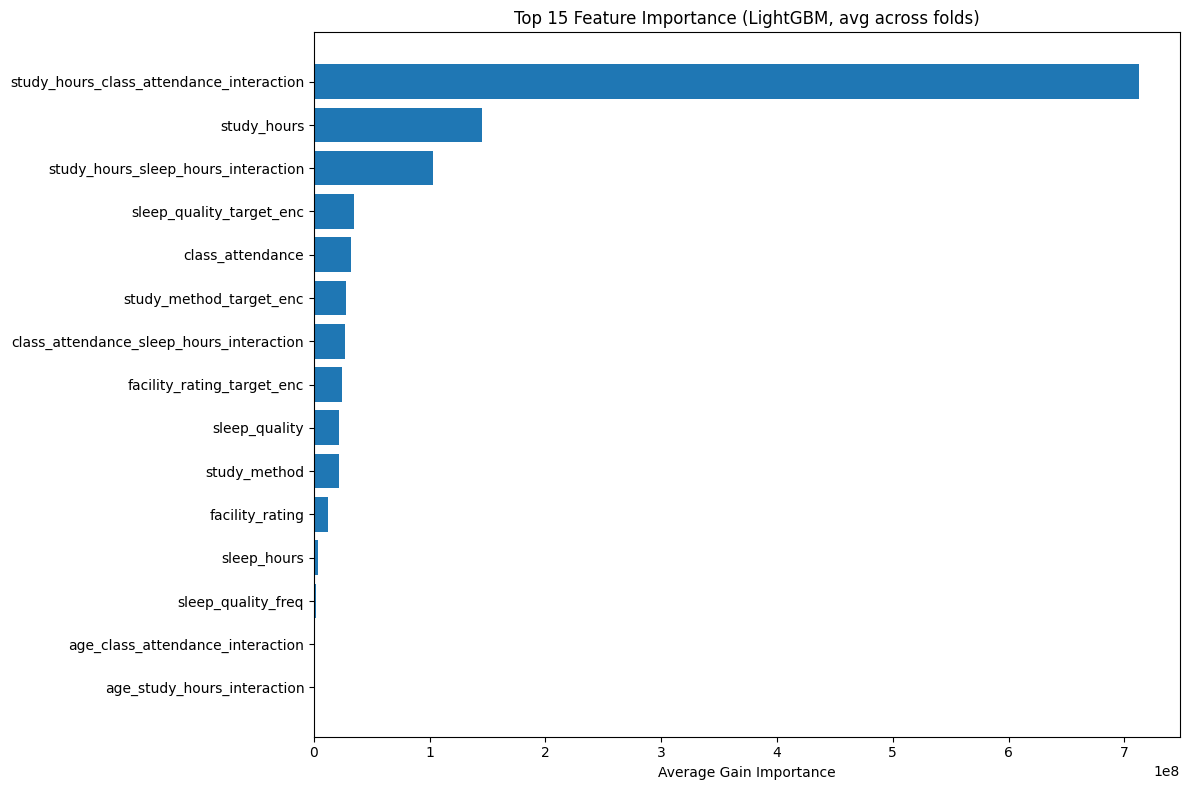

In [5]:
# ===========================================
# METHOD 1: LIGHTGBM (FINAL, SAFE)
# ===========================================

print("=== METHOD 1: LIGHTGBM WITH ADVANCED FEATURE ENGINEERING ===\n")

lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "random_state": CFG.SEED,
    "max_depth": -1,
    "min_child_samples": 20,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "verbose": -1,
}

folds = KFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=CFG.SEED)

oof_predictions = np.zeros(len(X_train), dtype=np.float32)
test_predictions = np.zeros(len(X_test), dtype=np.float32)
cv_scores = []
fold_importances = []

print(f"Training with {CFG.N_FOLDS}-fold CV...")
print(f"Train rows: {len(X_train)} | Features: {X_train.shape[1]}")

for fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train), start=1):
    print(f"\nFold {fold}/{CFG.N_FOLDS}")

    X_fold_train, X_fold_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_fold_train, y_fold_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    train_dataset = lgb.Dataset(X_fold_train, label=y_fold_train)
    valid_dataset = lgb.Dataset(X_fold_valid, label=y_fold_valid)

    model = lgb.train(
        lgb_params,
        train_dataset,
        valid_sets=[valid_dataset],
        valid_names=["valid"],
        num_boost_round=10000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0),
        ],
    )

    # OOF + test
    oof_predictions[valid_idx] = model.predict(X_fold_valid, num_iteration=model.best_iteration)
    test_predictions += model.predict(X_test, num_iteration=model.best_iteration) / CFG.N_FOLDS

    # Score
    fold_rmse = np.sqrt(mean_squared_error(y_fold_valid, oof_predictions[valid_idx]))
    cv_scores.append(fold_rmse)
    print(f"Fold RMSE: {fold_rmse:.5f}")

    # Importance
    fold_importances.append(model.feature_importance(importance_type="gain"))

    del model, train_dataset, valid_dataset
    gc.collect()

cv_mean = float(np.mean(cv_scores))
cv_std = float(np.std(cv_scores))
print("\n=== CV RESULTS ===")
print(f"Mean RMSE: {cv_mean:.5f} ± {cv_std:.5f}")
print(f"Fold scores: {[f'{s:.5f}' for s in cv_scores]}")

# Clip predictions
min_target, max_target = float(y_train.min()), float(y_train.max())
method_1_predictions = np.clip(test_predictions, min_target, max_target).astype(np.float32)
print(f"\nClipping predictions to range [{min_target:.1f}, {max_target:.1f}]")
print(f"Method 1 predictions shape: {method_1_predictions.shape}")

# Feature importance avg
avg_gain = np.mean(np.vstack(fold_importances), axis=0)
feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": avg_gain
}).sort_values("importance", ascending=False)

print("\nTop 15 Important Features:")
print(feature_importance.head(15))

plt.figure(figsize=(12, 8))
top15 = feature_importance.head(15).iloc[::-1]
plt.barh(top15["feature"], top15["importance"])
plt.xlabel("Average Gain Importance")
plt.title("Top 15 Feature Importance (LightGBM, avg across folds)")
plt.tight_layout()
plt.savefig(f"{CFG.OUTPUT_DIR}feature_importance_lgbm.png", dpi=300, bbox_inches="tight")
plt.show()

## Method 2: Ensemble Approach <a id='method2'></a>

In [6]:
# ===========================================
# METHOD 2: ENSEMBLE (LGB + XGB + CAT) FINAL
# ===========================================

RUN_METHOD_2 = True
method_2_predictions = None

if RUN_METHOD_2:
    print("=== METHOD 2: ENSEMBLE APPROACH ===\n")

    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "learning_rate": 0.05,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.9,
        "random_state": CFG.SEED,
        "n_estimators": 5000,
        "reg_alpha": 0.1,
        "reg_lambda": 0.1,
        "tree_method": "gpu_hist",  # fallback handled below
    }

    cat_params_gpu = {
        "loss_function": "RMSE",
        "learning_rate": 0.05,
        "depth": 6,
        "l2_leaf_reg": 3,
        "random_seed": CFG.SEED,
        "verbose": False,
        "iterations": 5000,
        "task_type": "GPU",
        "devices": "0",
    }

    cat_params_cpu = dict(cat_params_gpu)
    cat_params_cpu.pop("task_type", None)
    cat_params_cpu.pop("devices", None)

    folds = KFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=CFG.SEED)

    oof_lgb = np.zeros(len(X_train), dtype=np.float32)
    oof_xgb = np.zeros(len(X_train), dtype=np.float32)
    oof_cat = np.zeros(len(X_train), dtype=np.float32)

    preds_lgb = np.zeros(len(X_test), dtype=np.float32)
    preds_xgb = np.zeros(len(X_test), dtype=np.float32)
    preds_cat = np.zeros(len(X_test), dtype=np.float32)

    for fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train), start=1):
        print(f"Fold {fold}/{CFG.N_FOLDS}")

        X_fold_train, X_fold_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_fold_train, y_fold_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # LightGBM
        train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
        valid_data = lgb.Dataset(X_fold_valid, label=y_fold_valid)

        model_lgb = lgb.train(
            lgb_params,
            train_data,
            valid_sets=[valid_data],
            valid_names=["valid"],
            num_boost_round=20000,
            callbacks=[lgb.early_stopping(200, verbose=False), lgb.log_evaluation(0)],
        )

        oof_lgb[valid_idx] = model_lgb.predict(X_fold_valid, num_iteration=model_lgb.best_iteration)
        preds_lgb += model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration) / CFG.N_FOLDS

        # XGBoost
        try:
            model_xgb = xgb.XGBRegressor(**xgb_params)
            cb_es = xgb.callback.EarlyStopping(rounds=200, save_best=True)

            model_xgb.fit(
                X_fold_train, y_fold_train,
                eval_set=[(X_fold_valid, y_fold_valid)],
                verbose=False,
                callbacks=[cb_es],
            )

            oof_xgb[valid_idx] = model_xgb.predict(X_fold_valid)
            preds_xgb += model_xgb.predict(X_test) / CFG.N_FOLDS

            del model_xgb
            gc.collect()

        except Exception:
            # fallback: xgb.train
            params = xgb_params.copy()
            num_boost_round = int(params.pop("n_estimators", 5000))
            params["verbosity"] = 0
            params["seed"] = CFG.SEED
            params.pop("random_state", None)

            # if GPU fails in fallback, switch to hist
            try:
                dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
                dvalid = xgb.DMatrix(X_fold_valid, label=y_fold_valid)
                dtest = xgb.DMatrix(X_test)

                bst = xgb.train(
                    params,
                    dtrain,
                    num_boost_round=num_boost_round,
                    evals=[(dvalid, "valid")],
                    early_stopping_rounds=200,
                    verbose_eval=False
                )
            except Exception:
                params["tree_method"] = "hist"
                dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
                dvalid = xgb.DMatrix(X_fold_valid, label=y_fold_valid)
                dtest = xgb.DMatrix(X_test)

                bst = xgb.train(
                    params,
                    dtrain,
                    num_boost_round=num_boost_round,
                    evals=[(dvalid, "valid")],
                    early_stopping_rounds=200,
                    verbose_eval=False
                )

            oof_xgb[valid_idx] = bst.predict(dvalid, iteration_range=(0, bst.best_iteration + 1))
            preds_xgb += bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1)) / CFG.N_FOLDS

            del bst, dtrain, dvalid, dtest
            gc.collect()

        # CatBoost (GPU, fallback to CPU)
        try:
            model_cat = cb.CatBoostRegressor(**cat_params_gpu)
        except Exception:
            model_cat = cb.CatBoostRegressor(**cat_params_cpu)

        model_cat.fit(
            X_fold_train, y_fold_train,
            eval_set=(X_fold_valid, y_fold_valid),
            verbose=False,
            early_stopping_rounds=200
        )

        oof_cat[valid_idx] = model_cat.predict(X_fold_valid)
        preds_cat += model_cat.predict(X_test) / CFG.N_FOLDS

        del model_lgb, model_cat, train_data, valid_data
        gc.collect()

    # Weighted ensemble
    w_lgb, w_xgb, w_cat = 0.4, 0.3, 0.3
    oof_ensemble = w_lgb * oof_lgb + w_xgb * oof_xgb + w_cat * oof_cat
    test_ensemble = w_lgb * preds_lgb + w_xgb * preds_xgb + w_cat * preds_cat

    ensemble_rmse = np.sqrt(mean_squared_error(y_train, oof_ensemble))
    print(f"\nEnsemble CV RMSE: {ensemble_rmse:.5f}")

    min_target, max_target = float(y_train.min()), float(y_train.max())
    method_2_predictions = np.clip(test_ensemble, min_target, max_target).astype(np.float32)
    print(f"Method 2 predictions shape: {method_2_predictions.shape}")

else:
    print("Method 2 skipped (RUN_METHOD_2=False)")

=== METHOD 2: ENSEMBLE APPROACH ===

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Ensemble CV RMSE: 8.76962
Method 2 predictions shape: (270000,)


## Method 3: Neural Network + GBDT Hybrid <a id='method3'></a>

In [7]:
# ===========================================
# METHOD 3: NEURAL NET + BLEND FINAL
# ===========================================

RUN_METHOD_3 = True
method_3_predictions = None

if RUN_METHOD_3:
    print("=== METHOD 3: NEURAL NETWORK + BLEND ===\n")

    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset

    if "method_1_predictions" not in globals() or method_1_predictions is None:
        raise ValueError("Run Method 1 first. Method 3 blends with Method 1.")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    class StudentNet(nn.Module):
        def __init__(self, input_size):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, 1),
            )

        def forward(self, x):
            return self.net(x)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_nn = StudentNet(X_train_scaled.shape[1]).to(device)

    batch_size = 256
    epochs = 10
    lr = 1e-3

    loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size,
        shuffle=True
    )

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_nn.parameters(), lr=lr)

    model_nn.train()
    for epoch in range(epochs):
        total = 0.0
        for bx, by in loader:
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()
            pred = model_nn(bx)
            loss = criterion(pred, by)
            loss.backward()
            optimizer.step()
            total += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {total/len(loader):.5f}")

    model_nn.eval()
    with torch.no_grad():
        nn_test_pred = model_nn(X_test_tensor.to(device)).cpu().numpy().flatten().astype(np.float32)

    blend_weight = 0.85
    blended = blend_weight * method_1_predictions + (1 - blend_weight) * nn_test_pred

    min_target, max_target = float(y_train.min()), float(y_train.max())
    method_3_predictions = np.clip(blended, min_target, max_target).astype(np.float32)

    print(f"\nMethod 3 predictions shape: {method_3_predictions.shape}")

else:
    print("Method 3 skipped (RUN_METHOD_3=False)")

=== METHOD 3: NEURAL NETWORK + BLEND ===

Epoch 1/10 Loss: 611.63147
Epoch 2/10 Loss: 120.43486
Epoch 3/10 Loss: 117.01284
Epoch 4/10 Loss: 114.74493
Epoch 5/10 Loss: 113.21042
Epoch 6/10 Loss: 111.90033
Epoch 7/10 Loss: 109.97612
Epoch 8/10 Loss: 109.34815
Epoch 9/10 Loss: 108.56811
Epoch 10/10 Loss: 107.18359

Method 3 predictions shape: (270000,)


## Submission <a id='submission'></a>

In [8]:
# ===========================================
# SUBMISSIONS: METHOD1 + METHOD2 + METHOD3 + BLEND (4 FILES)
# ===========================================

print("=== SUBMISSIONS ===\n")

def save_submission(preds, filename):
    sub = pd.DataFrame({"id": test_ids, "exam_score": preds})
    path = f"{CFG.OUTPUT_DIR}{filename}"
    sub.to_csv(path, index=False)
    print(f"Saved: {path} | shape={sub.shape}")
    return path

created = []

# Method 1 required
if "method_1_predictions" not in globals() or method_1_predictions is None:
    raise ValueError("Method 1 predictions not found. Run Method 1 first.")
created.append(save_submission(method_1_predictions, "submission_method1.csv"))

# Method 2 optional
if "method_2_predictions" in globals() and method_2_predictions is not None:
    created.append(save_submission(method_2_predictions, "submission_method2.csv"))
else:
    print("Method 2 not available, skipping submission_method2.csv")

# Method 3 optional
if "method_3_predictions" in globals() and method_3_predictions is not None:
    created.append(save_submission(method_3_predictions, "submission_method3.csv"))
else:
    print("Method 3 not available, skipping submission_method3.csv")

# Blend (uses whatever exists)
w1, w2, w3 = 0.60, 0.25, 0.15
parts = [method_1_predictions]
weights = [w1]

if "method_2_predictions" in globals() and method_2_predictions is not None:
    parts.append(method_2_predictions)
    weights.append(w2)

if "method_3_predictions" in globals() and method_3_predictions is not None:
    parts.append(method_3_predictions)
    weights.append(w3)

weights = np.array(weights, dtype=np.float32)
weights = weights / weights.sum()

blend_pred = np.zeros_like(method_1_predictions, dtype=np.float32)
for p, w in zip(parts, weights):
    blend_pred += p.astype(np.float32) * w

min_target, max_target = float(y_train.min()), float(y_train.max())
blend_pred = np.clip(blend_pred, min_target, max_target).astype(np.float32)

created.append(save_submission(blend_pred, "submission_blend.csv"))

print("\nAll files created:")
for p in created:
    print(p)

=== SUBMISSIONS ===

Saved: /kaggle/working/submission_method1.csv | shape=(270000, 2)
Saved: /kaggle/working/submission_method2.csv | shape=(270000, 2)
Saved: /kaggle/working/submission_method3.csv | shape=(270000, 2)
Saved: /kaggle/working/submission_blend.csv | shape=(270000, 2)

All files created:
/kaggle/working/submission_method1.csv
/kaggle/working/submission_method2.csv
/kaggle/working/submission_method3.csv
/kaggle/working/submission_blend.csv
